Training label counts: Counter({0: 14716, 1: 4210})
Test label counts: Counter({0: 3679, 1: 1053})


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed 


Epoch 1/3


Epoch 1 Training Loss: 0.5294

Epoch 2/3


Epoch 2 Training Loss: 0.5013

Epoch 3/3


Epoch 3 Training Loss: 0.3874

Evaluating model on test set...



Final Evaluation Metrics:
Accuracy:  0.7673
Precision: 0.3919
Recall:    0.0826
F1 Score:  0.1365
AUC:       0.5230

Model and tokenizer saved to ./bert_finetuned_04_no_upsampling

Classification Report:
              precision    recall  f1-score   support

           0     0.7858    0.9633    0.8656      3679
           1     0.3919    0.0826    0.1365      1053

    accuracy                         0.7673      4732
   macro avg     0.5889    0.5230    0.5010      4732
weighted avg     0.6982    0.7673    0.7033      4732



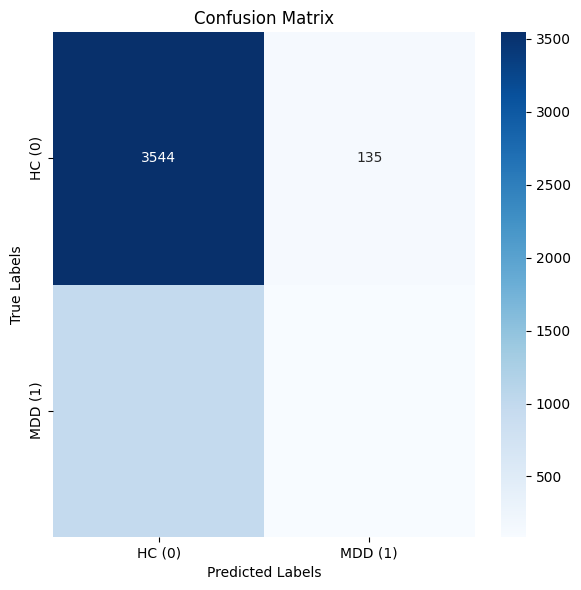

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from collections import Counter

# Load dataset
data = pd.read_csv('Data_edaic/04_sec.csv')
texts = data['text'].astype(str).tolist()
labels = data['label'].tolist()

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

print("Training label counts:", Counter(train_labels))
print("Test label counts:", Counter(test_labels))

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long),
        }

# Create datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Batch Loss': loss.item()})
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Training loop
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}")

# Evaluate
print("\nEvaluating model on test set...")
predictions, true_labels = evaluate(model, test_loader, device)

# Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
auc = roc_auc_score(true_labels, predictions)

print(f"\nFinal Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# Save model and tokenizer
model.save_pretrained('./bert_finetuned_04_no_upsampling')
tokenizer.save_pretrained('./bert_finetuned_04_no_upsampling')
print("\nModel and tokenizer saved to ./bert_finetuned_04_no_upsampling")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, digits=4))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['HC (0)', 'MDD (1)'],
                yticklabels=['HC (0)', 'MDD (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(conf_matrix)


In [6]:
# 4_seconds Two-Modality Classification using fine-tuned BERT + selected 56 acoustic features

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")
# ======================
# Load Data
# ======================
df = pd.read_csv("Data_edaic/04_sec.csv")  # or your uploaded path

texts = df["text"].astype(str).tolist()
labels = df["label"].values

# ======================
# Load selected acoustic feature names
# ======================
selected_features_path = "Data_edaic/selected_features_edaic_56.csv"
selected_features = pd.read_csv(selected_features_path)["Selected_Features"].tolist()

# Extract only the selected 56 features
acoustic_features = df[selected_features].values

# ======================
# Load fine-tuned BERT
# ======================
tokenizer = BertTokenizer.from_pretrained('./bert_finetuned_04_no_upsampling', local_files_only=True)
bert_model = BertModel.from_pretrained('./bert_finetuned_04_no_upsampling', local_files_only=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# ======================
# Extract BERT embeddings (CLS token)
# ======================
def get_bert_embeddings(texts, tokenizer, model, max_length=128):
    model.eval()
    embeddings = []
    for text in tqdm(texts, desc="Extracting BERT embeddings"):
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy().squeeze())
    return np.array(embeddings)

print("Extracting BERT embeddings...")
bert_embeddings = get_bert_embeddings(texts, tokenizer, bert_model)

# ======================
# Feature Combination
# ======================
scaler = StandardScaler()
acoustic_scaled = scaler.fit_transform(acoustic_features)

X_combined = np.hstack((bert_embeddings, acoustic_scaled))

# ======================
# Train/test split
# ======================
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)

print(f"\nShape of BERT: {bert_embeddings.shape}")
print(f"Shape of Acoustic: {acoustic_scaled.shape}")
print(f"Shape of Combined: {X_combined.shape}")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}\n")

# ======================
# Build Dense Model
# ======================
model = Sequential([
    Dense(128, input_dim=X_combined.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

log_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(
        f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
        f"Val_Loss: {logs['val_loss']:.4f}, "
        f"Acc: {logs['accuracy']:.4f}, "
        f"Val_Acc: {logs['val_accuracy']:.4f}"
    )
)

# ======================
# Train
# ======================
print("Training model...\n")
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=50, batch_size=32, verbose=0,
                    callbacks=[log_callback])

# ======================
# Evaluate
# ======================
print("\nEvaluating on test set...")
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# ======================
# Class Distribution
# ======================
val_size = int(0.2 * len(X_train))
y_train_final = y_train[:-val_size]
y_val = y_train[-val_size:]

def print_class_counts(name, labels):
    c = Counter(labels)
    print(f"{name} set — HC: {c[0]}, MDD: {c[1]}")

print_class_counts("Training", y_train_final)
print_class_counts("Validation", y_val)
print_class_counts("Test", y_test)

# ======================
# Save Outputs
# ======================
np.save("Data_edaic/bert_embeddings_04sec_no_upsampled.npy", bert_embeddings)
np.save("Data_edaic/acoustic_scaled_56_04sec_no_upsampled.npy", acoustic_scaled)
np.save("Data_edaic/labels_04sec_no_upsampled.npy", labels)
np.save("Data_edaic/combined_embeddings_04sec_no_upsampled.npy", X_combined)


Extracting BERT embeddings...


Extracting BERT embeddings: 100%|████████████████████████████████████████████████| 23658/23658 [33:25<00:00, 11.80it/s]
C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Shape of BERT: (23658, 768)
Shape of Acoustic: (23658, 56)
Shape of Combined: (23658, 824)
Training samples: 18926, Test samples: 4732

Training model...

Epoch 01 — Loss: 0.2459, Val_Loss: 0.3343, Acc: 0.9150, Val_Acc: 0.8716
Epoch 02 — Loss: 0.2241, Val_Loss: 0.3431, Acc: 0.9242, Val_Acc: 0.8666
Epoch 03 — Loss: 0.2136, Val_Loss: 0.3578, Acc: 0.9264, Val_Acc: 0.8576
Epoch 04 — Loss: 0.2061, Val_Loss: 0.3168, Acc: 0.9277, Val_Acc: 0.8767
Epoch 05 — Loss: 0.2001, Val_Loss: 0.3380, Acc: 0.9306, Val_Acc: 0.8777
Epoch 06 — Loss: 0.1906, Val_Loss: 0.3222, Acc: 0.9346, Val_Acc: 0.8714
Epoch 07 — Loss: 0.1856, Val_Loss: 0.3308, Acc: 0.9366, Val_Acc: 0.8674
Epoch 08 — Loss: 0.1766, Val_Loss: 0.3310, Acc: 0.9378, Val_Acc: 0.8724
Epoch 09 — Loss: 0.1715, Val_Loss: 0.3203, Acc: 0.9390, Val_Acc: 0.8793
Epoch 10 — Loss: 0.1648, Val_Loss: 0.3252, Acc: 0.9413, Val_Acc: 0.8727
Epoch 11 — Loss: 0.1531, Val_Loss: 0.3192, Acc: 0.9482, Val_Acc: 0.8840
Epoch 12 — Loss: 0.1465, Val_Loss: 0.3013, Acc: 0.94


--- Training on Text ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.2635, Val_Loss: 0.3766, Acc: 0.9090, Val_Acc: 0.8573
Epoch 02 — Loss: 0.2522, Val_Loss: 0.3959, Acc: 0.9130, Val_Acc: 0.8427
Epoch 03 — Loss: 0.2494, Val_Loss: 0.3750, Acc: 0.9132, Val_Acc: 0.8526
Epoch 04 — Loss: 0.2454, Val_Loss: 0.3484, Acc: 0.9152, Val_Acc: 0.8516
Epoch 05 — Loss: 0.2429, Val_Loss: 0.3562, Acc: 0.9142, Val_Acc: 0.8648
Epoch 06 — Loss: 0.2410, Val_Loss: 0.3442, Acc: 0.9161, Val_Acc: 0.8592
Epoch 07 — Loss: 0.2392, Val_Loss: 0.3621, Acc: 0.9162, Val_Acc: 0.8516
Epoch 08 — Loss: 0.2385, Val_Loss: 0.3585, Acc: 0.9171, Val_Acc: 0.8624
Epoch 09 — Loss: 0.2326, Val_Loss: 0.3805, Acc: 0.9200, Val_Acc: 0.8460
Epoch 10 — Loss: 0.2326, Val_Loss: 0.3603, Acc: 0.9180, Val_Acc: 0.8554
Epoch 11 — Loss: 0.2311, Val_Loss: 0.3662, Acc: 0.9198, Val_Acc: 0.8451
Epoch 12 — Loss: 0.2290, Val_Loss: 0.3554, Acc: 0.9182, Val_Acc: 0.8624
Epoch 13 — Loss: 0.2277, Val_Loss: 0.3442, Acc: 0.9197, Val_Acc: 0.8559
Epoch 14 — Loss: 0.2269, Val_Loss: 0.3496, Acc: 0.9204, Val_Acc:

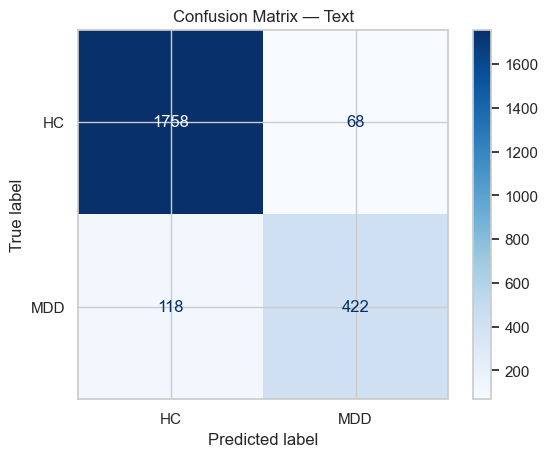

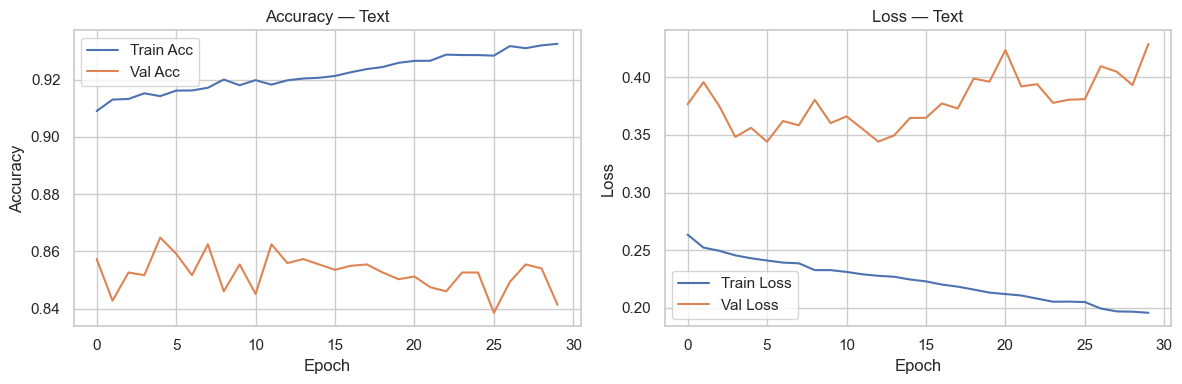

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Text+Audio ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.2546, Val_Loss: 0.3521, Acc: 0.9112, Val_Acc: 0.8615
Epoch 02 — Loss: 0.2365, Val_Loss: 0.3252, Acc: 0.9172, Val_Acc: 0.8662
Epoch 03 — Loss: 0.2247, Val_Loss: 0.3170, Acc: 0.9206, Val_Acc: 0.8742
Epoch 04 — Loss: 0.2165, Val_Loss: 0.3499, Acc: 0.9234, Val_Acc: 0.8563
Epoch 05 — Loss: 0.2082, Val_Loss: 0.2922, Acc: 0.9265, Val_Acc: 0.8812
Epoch 06 — Loss: 0.2006, Val_Loss: 0.2991, Acc: 0.9295, Val_Acc: 0.8840
Epoch 07 — Loss: 0.1943, Val_Loss: 0.3112, Acc: 0.9309, Val_Acc: 0.8737
Epoch 08 — Loss: 0.1840, Val_Loss: 0.3181, Acc: 0.9352, Val_Acc: 0.8784
Epoch 09 — Loss: 0.1754, Val_Loss: 0.3179, Acc: 0.9384, Val_Acc: 0.8765
Epoch 10 — Loss: 0.1654, Val_Loss: 0.3061, Acc: 0.9406, Val_Acc: 0.8779
Epoch 11 — Loss: 0.1609, Val_Loss: 0.3226, Acc: 0.9450, Val_Acc: 0.8737
Epoch 12 — Loss: 0.1518, Val_Loss: 0.2953, Acc: 0.9483, Val_Acc: 0.8836
Epoch 13 — Loss: 0.1488, Val_Loss: 0.3357, Acc: 0.9483, Val_Acc: 0.8845
Epoch 14 — Loss: 0.1413, Val_Loss: 0.3252, Acc: 0.9498, Val_Acc:

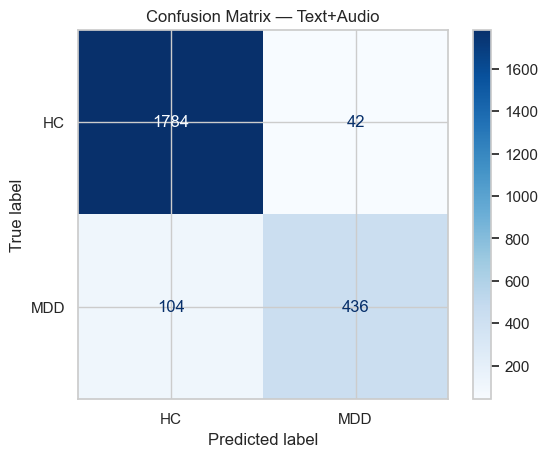

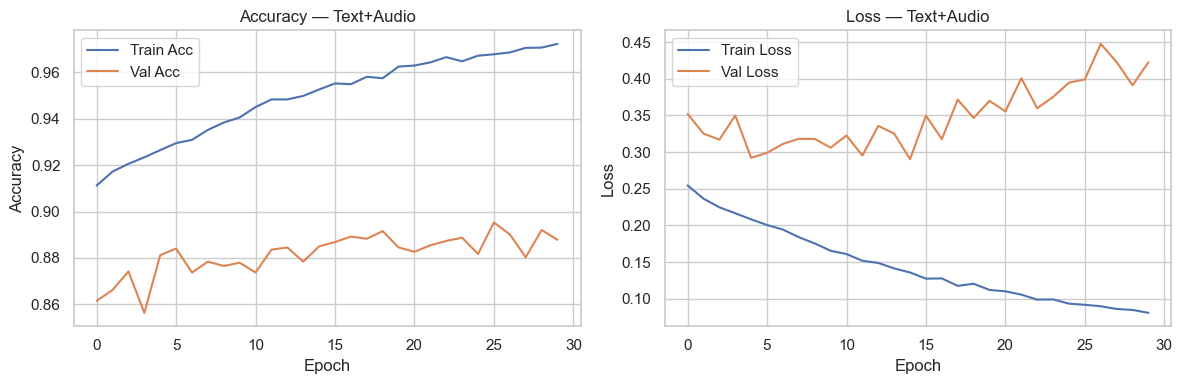

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

 Ablation Study Comparison (Simple Dense):
            Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                 
Text          0.9214     0.8612  0.7815    0.8194  0.8721
Text+Audio    0.9383     0.9121  0.8074    0.8566  0.8922


In [6]:
#Dense
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Set style
sns.set(style="whitegrid")

# ======================
# Load Saved Data
# ======================
bert = np.load("Data_edaic/bert_embeddings_04sec_no_upsampled.npy")
# acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec_no_upsampled.npy")
labels = np.load("Data_edaic/labels_04sec_no_upsampled.npy")
combined = np.load("Data_edaic/combined_embeddings_04sec_no_upsampled.npy")

# ======================
# Setup
# ======================
os.makedirs("Results_04sec_ablation_dense", exist_ok=True)

# For comparison table
results = []

def build_dnn_model(input_dim):
    return Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def evaluate_model(X, y, modality_name):
    print(f"\n--- Training on {modality_name} ---")

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = build_dnn_model(X.shape[1])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.1,
                        epochs=30, batch_size=32, verbose=0,
                        callbacks=[LambdaCallback(
                            on_epoch_end=lambda epoch, logs: print(
                                f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
                                f"Val_Loss: {logs['val_loss']:.4f}, "
                                f"Acc: {logs['accuracy']:.4f}, "
                                f"Val_Acc: {logs['val_accuracy']:.4f}"
                            ))])

    # Prediction
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"Results_04sec_ablation_dense/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    # Plot history
    def plot_history(history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f"Accuracy — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"Results_04sec_ablation_dense/history_{modality_name.replace('+','_')}.png")
        plt.show()

    plot_history(history)

    # Class Distribution
    def print_class_counts(name, y):
        c = Counter(y)
        print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    # Append results
    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# ======================
# Run Ablation
# ======================
evaluate_model(bert, labels, "Text")
# evaluate_model(acoustic, labels, "Audio")
evaluate_model(combined, labels, "Text+Audio")

# ======================
# Print Comparison Table
# ======================
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Modality")
df_results = df_results.round(4)

print("\n Ablation Study Comparison (Simple Dense):")
print(df_results)

df_results.to_csv("Results_04sec_ablation_dense/ablation_comparison.csv")



--- Training on Text (1DCNN) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.2632, Val_Loss: 0.3537, Acc: 0.9044, Val_Acc: 0.8587
Epoch 02 — Loss: 0.2463, Val_Loss: 0.3613, Acc: 0.9131, Val_Acc: 0.8535
Epoch 03 — Loss: 0.2421, Val_Loss: 0.3707, Acc: 0.9144, Val_Acc: 0.8535
Epoch 04 — Loss: 0.2404, Val_Loss: 0.4067, Acc: 0.9135, Val_Acc: 0.8324
Epoch 05 — Loss: 0.2380, Val_Loss: 0.3543, Acc: 0.9147, Val_Acc: 0.8568
Epoch 06 — Loss: 0.2359, Val_Loss: 0.3333, Acc: 0.9154, Val_Acc: 0.8746
Epoch 07 — Loss: 0.2342, Val_Loss: 0.3978, Acc: 0.9160, Val_Acc: 0.8385
Epoch 08 — Loss: 0.2316, Val_Loss: 0.3480, Acc: 0.9161, Val_Acc: 0.8587
Epoch 09 — Loss: 0.2291, Val_Loss: 0.3690, Acc: 0.9169, Val_Acc: 0.8554
Epoch 10 — Loss: 0.2273, Val_Loss: 0.3697, Acc: 0.9179, Val_Acc: 0.8512
Epoch 11 — Loss: 0.2241, Val_Loss: 0.3682, Acc: 0.9177, Val_Acc: 0.8531
Epoch 12 — Loss: 0.2199, Val_Loss: 0.3835, Acc: 0.9211, Val_Acc: 0.8380
Epoch 13 — Loss: 0.2178, Val_Loss: 0.3785, Acc: 0.9197, Val_Acc: 0.8507
Epoch 14 — Loss: 0.2135, Val_Loss: 0.3901, Acc: 0.9214, Val_Acc:

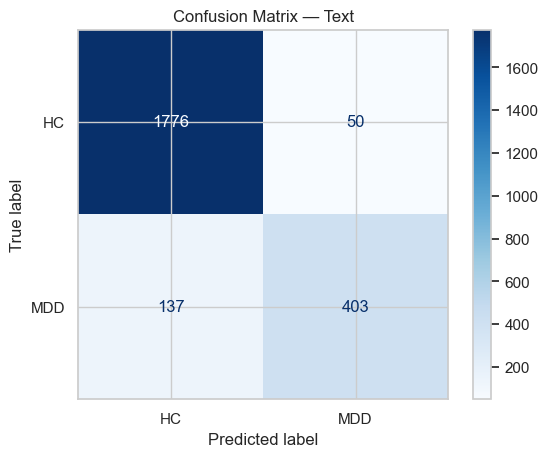

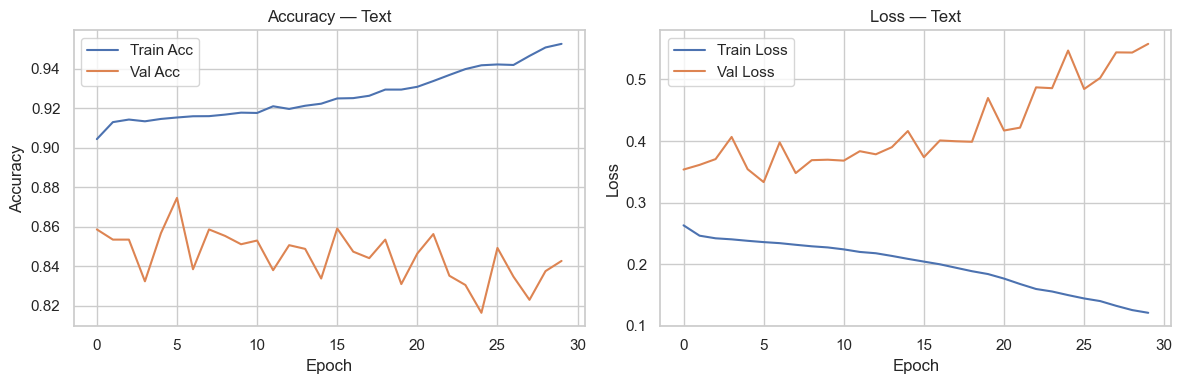

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Text+Audio (1DCNN) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 — Loss: 0.2548, Val_Loss: 0.3335, Acc: 0.9083, Val_Acc: 0.8690
Epoch 02 — Loss: 0.2263, Val_Loss: 0.3395, Acc: 0.9169, Val_Acc: 0.8685
Epoch 03 — Loss: 0.2157, Val_Loss: 0.3708, Acc: 0.9218, Val_Acc: 0.8451
Epoch 04 — Loss: 0.2068, Val_Loss: 0.3472, Acc: 0.9241, Val_Acc: 0.8568
Epoch 05 — Loss: 0.1991, Val_Loss: 0.3247, Acc: 0.9266, Val_Acc: 0.8793
Epoch 06 — Loss: 0.1936, Val_Loss: 0.3064, Acc: 0.9283, Val_Acc: 0.8775
Epoch 07 — Loss: 0.1909, Val_Loss: 0.3056, Acc: 0.9267, Val_Acc: 0.8798
Epoch 08 — Loss: 0.1840, Val_Loss: 0.2889, Acc: 0.9317, Val_Acc: 0.8845
Epoch 09 — Loss: 0.1820, Val_Loss: 0.3032, Acc: 0.9315, Val_Acc: 0.8808
Epoch 10 — Loss: 0.1798, Val_Loss: 0.2971, Acc: 0.9320, Val_Acc: 0.8789
Epoch 11 — Loss: 0.1757, Val_Loss: 0.2911, Acc: 0.9338, Val_Acc: 0.8840
Epoch 12 — Loss: 0.1727, Val_Loss: 0.3012, Acc: 0.9350, Val_Acc: 0.8803
Epoch 13 — Loss: 0.1666, Val_Loss: 0.2971, Acc: 0.9386, Val_Acc: 0.8831
Epoch 14 — Loss: 0.1596, Val_Loss: 0.3086, Acc: 0.9382, Val_Acc:

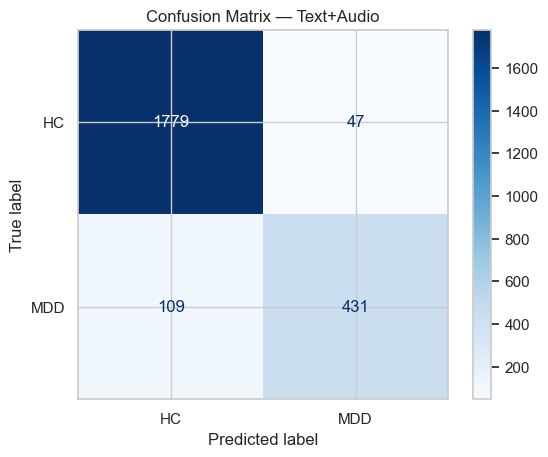

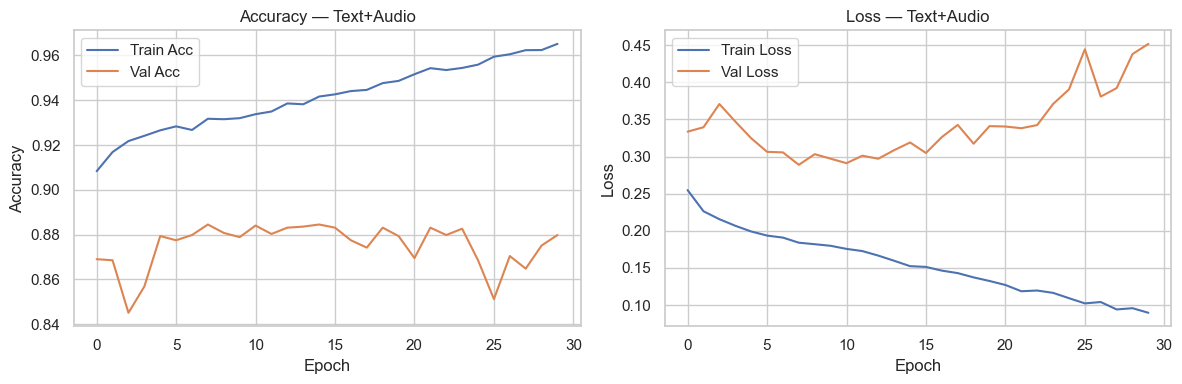

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

 Ablation Study Comparison (1DCNN):
            Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                 
Text          0.9210     0.8896  0.7463    0.8117  0.8595
Text+Audio    0.9341     0.9017  0.7981    0.8468  0.8862


In [7]:
#1DCNN
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Set plot style
sns.set(style="whitegrid")

# ======================
# Load Saved Data
# ======================
bert = np.load("Data_edaic/bert_embeddings_04sec_no_upsampled.npy")
# acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec_no_upsampled.npy")
labels = np.load("Data_edaic/labels_04sec_no_upsampled.npy")
combined = np.load("Data_edaic/combined_embeddings_04sec_no_upsampled.npy")

# ======================
# Setup
# ======================
output_dir = "Results_04sec_ablation_1dcnn"
os.makedirs(output_dir, exist_ok=True)

results = []

# ======================
# Model Builder
# ======================
def build_1dcnn_model(input_shape):
    return Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

# ======================
# Evaluation Function
# ======================
def evaluate_model(X, y, modality_name):
    print(f"\n--- Training on {modality_name} (1DCNN) ---")

    # Reshape for Conv1D: (samples, time_steps, features=1)
    X = np.expand_dims(X, axis=2)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = build_1dcnn_model(input_shape=X.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.1,
                        epochs=30, batch_size=32, verbose=0,
                        callbacks=[LambdaCallback(
                            on_epoch_end=lambda epoch, logs: print(
                                f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
                                f"Val_Loss: {logs['val_loss']:.4f}, "
                                f"Acc: {logs['accuracy']:.4f}, "
                                f"Val_Acc: {logs['val_accuracy']:.4f}"
                            ))])

    # Prediction
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"{output_dir}/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    # Training Curves
    def plot_history(history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f"Accuracy — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{output_dir}/history_{modality_name.replace('+','_')}.png")
        plt.show()

    plot_history(history)

    # Print class distribution
    def print_class_counts(name, y):
        c = Counter(y)
        print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    # Save metrics
    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# ======================
# Run Ablation
# ======================
evaluate_model(bert, labels, "Text")
# evaluate_model(acoustic, labels, "Audio")
evaluate_model(combined, labels, "Text+Audio")

# ======================
# Print Comparison Table
# ======================
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Modality")
df_results = df_results.round(4)

print("\n Ablation Study Comparison (1DCNN):")
print(df_results)

df_results.to_csv(f"{output_dir}/ablation_comparison.csv")



--- Training on Text (LSTM) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 01 — Loss: 0.2581, Val_Loss: 0.3454, Acc: 0.9104, Val_Acc: 0.8629
Epoch 02 — Loss: 0.2450, Val_Loss: 0.3719, Acc: 0.9136, Val_Acc: 0.8479
Epoch 03 — Loss: 0.2413, Val_Loss: 0.3728, Acc: 0.9155, Val_Acc: 0.8498
Epoch 04 — Loss: 0.2378, Val_Loss: 0.3511, Acc: 0.9162, Val_Acc: 0.8671
Epoch 05 — Loss: 0.2350, Val_Loss: 0.3673, Acc: 0.9171, Val_Acc: 0.8512
Epoch 06 — Loss: 0.2321, Val_Loss: 0.3579, Acc: 0.9182, Val_Acc: 0.8606
Epoch 07 — Loss: 0.2298, Val_Loss: 0.3860, Acc: 0.9201, Val_Acc: 0.8535
Epoch 08 — Loss: 0.2258, Val_Loss: 0.3790, Acc: 0.9199, Val_Acc: 0.8568
Epoch 09 — Loss: 0.2234, Val_Loss: 0.4057, Acc: 0.9219, Val_Acc: 0.8441
Epoch 10 — Loss: 0.2222, Val_Loss: 0.3901, Acc: 0.9211, Val_Acc: 0.8488
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.937     0.968     0.952      1826
           1      0.877     0.781     0.827       540

    accuracy                          0.925      2366

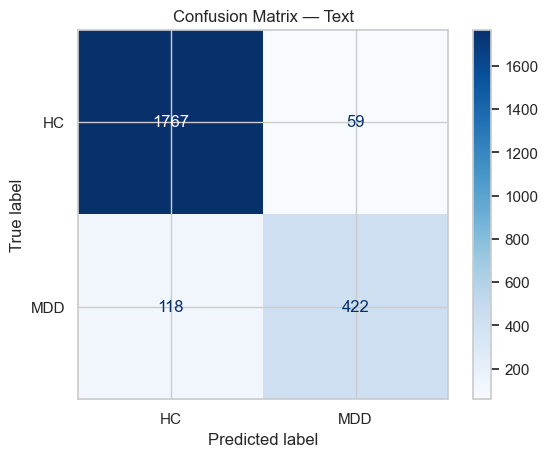

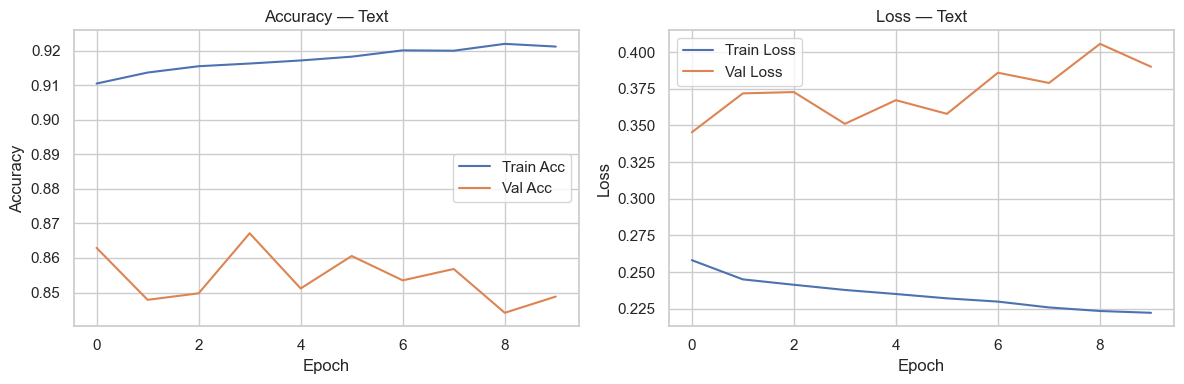

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

--- Training on Text+Audio (LSTM) ---


C:\Users\Administrator\.conda\envs\p311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 01 — Loss: 0.2459, Val_Loss: 0.3637, Acc: 0.9136, Val_Acc: 0.8615
Epoch 02 — Loss: 0.2247, Val_Loss: 0.3376, Acc: 0.9195, Val_Acc: 0.8709
Epoch 03 — Loss: 0.2112, Val_Loss: 0.3433, Acc: 0.9244, Val_Acc: 0.8695
Epoch 04 — Loss: 0.2020, Val_Loss: 0.3095, Acc: 0.9277, Val_Acc: 0.8798
Epoch 05 — Loss: 0.1890, Val_Loss: 0.3315, Acc: 0.9324, Val_Acc: 0.8653
Epoch 06 — Loss: 0.1826, Val_Loss: 0.3285, Acc: 0.9347, Val_Acc: 0.8718
Epoch 07 — Loss: 0.1672, Val_Loss: 0.3182, Acc: 0.9402, Val_Acc: 0.8775
Epoch 08 — Loss: 0.1603, Val_Loss: 0.3342, Acc: 0.9434, Val_Acc: 0.8873
Epoch 09 — Loss: 0.1533, Val_Loss: 0.3146, Acc: 0.9455, Val_Acc: 0.8808
Epoch 10 — Loss: 0.1436, Val_Loss: 0.3157, Acc: 0.9493, Val_Acc: 0.8873
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.951     0.975     0.963      1826
           1      0.909     0.830     0.867       540

    accuracy                          0.942      2366

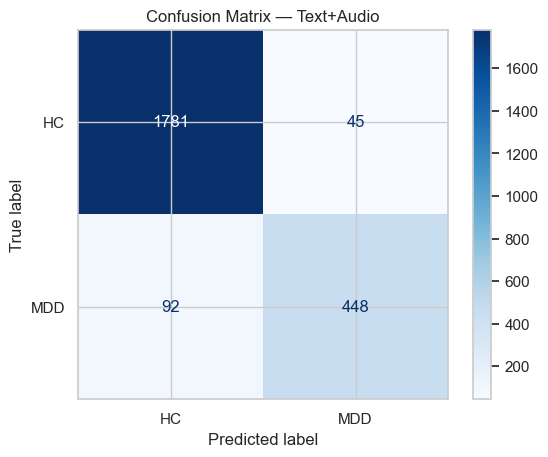

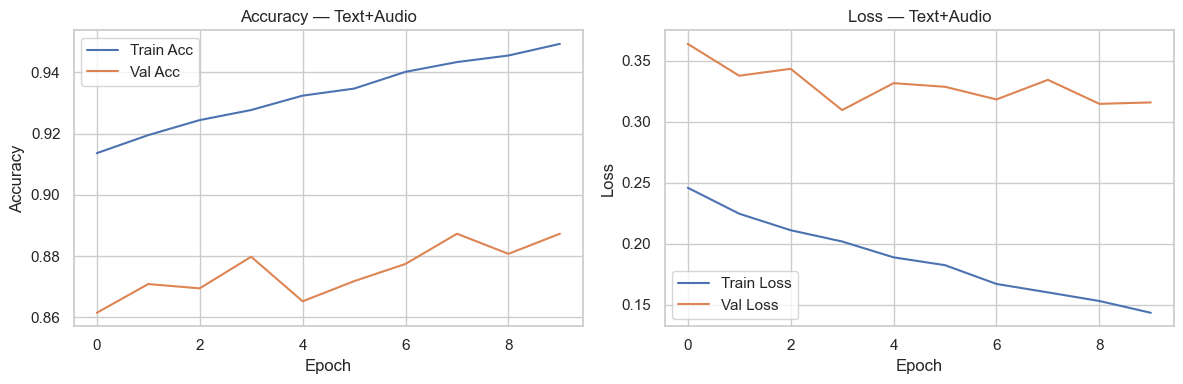

Train — HC: 13310, MDD: 3724
Val — HC: 3259, MDD: 999
Test — HC: 1826, MDD: 540

Ablation Study Comparison (LSTM):
            Accuracy  Precision  Recall  F1 Score     AUC
Modality                                                 
Text          0.9252     0.8773  0.7815    0.8266  0.8746
Text+Audio    0.9421     0.9087  0.8296    0.8674  0.9025


In [10]:
#LSTM
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Set plot style
sns.set(style="whitegrid")

# ======================
# Load Saved Data
# ======================
bert = np.load("Data_edaic/bert_embeddings_04sec_no_upsampled.npy")
# acoustic = np.load("Data_edaic/acoustic_scaled_56_04sec_no_upsampled.npy")
labels = np.load("Data_edaic/labels_04sec_no_upsampled.npy")
combined = np.load("Data_edaic/combined_embeddings_04sec_no_upsampled.npy")

# ======================
# Setup
# ======================
output_dir = "Results_04sec_ablation_lstm"
os.makedirs(output_dir, exist_ok=True)

results = []



# ======================
# Model Builder (LSTM)
# ======================
def build_lstm_model(input_shape):
    return Sequential([
        LSTM(32, return_sequences=False, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])



# ======================
# Evaluation Function
# ======================
def evaluate_model(X, y, modality_name):
    print(f"\n--- Training on {modality_name} (LSTM) ---")

    # Reshape for LSTM: (samples, time_steps, features)
    X = np.expand_dims(X, axis=1)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    val_size = int(0.2 * len(X_train))
    y_train_final = y_train[:-val_size]
    y_val = y_train[-val_size:]

    model = build_lstm_model(input_shape=X.shape[1:])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.1,
                        epochs=10, batch_size=32, verbose=0,
                        callbacks=[LambdaCallback(
                            on_epoch_end=lambda epoch, logs: print(
                                f"Epoch {epoch+1:02d} — Loss: {logs['loss']:.4f}, "
                                f"Val_Loss: {logs['val_loss']:.4f}, "
                                f"Acc: {logs['accuracy']:.4f}, "
                                f"Val_Acc: {logs['val_accuracy']:.4f}"
                            ))])

    # Prediction
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3, zero_division=0))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "MDD"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {modality_name}")
    plt.savefig(f"{output_dir}/conf_matrix_{modality_name.replace('+','_')}.png")
    plt.show()

    # Training Curves
    def plot_history(history):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f"Accuracy — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss — {modality_name}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{output_dir}/history_{modality_name.replace('+','_')}.png")
        plt.show()

    plot_history(history)

    # Print class distribution
    def print_class_counts(name, y):
        c = Counter(y)
        print(f"{name} — HC: {c[0]}, MDD: {c[1]}")

    print_class_counts("Train", y_train_final)
    print_class_counts("Val", y_val)
    print_class_counts("Test", y_test)

    # Save metrics
    results.append({
        "Modality": modality_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC": auc
    })

# ======================
# Run Ablation
# ======================
evaluate_model(bert, labels, "Text")
# evaluate_model(acoustic, labels, "Audio")
evaluate_model(combined, labels, "Text+Audio")

# ======================
# Print Comparison Table
# ======================
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Modality")
df_results = df_results.round(4)

print("\nAblation Study Comparison (LSTM):")
print(df_results)

df_results.to_csv(f"{output_dir}/ablation_comparison.csv")

